# Practical Statistics for Data Scientists (Python)
# Chapter 4. Regression and Prediction
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [3]:
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

no display found. Using non-interactive Agg backend


In [4]:
%matplotlib inline

In [5]:
try:
    import common
    DATA = common.data_dir()
except ImportError:
    DATA = Path().resolve() / "data"

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [58]:
LUNG_CSV = DATA / "lung_disease.csv"
HOUSE_PARQUET = DATA / "house_sales.parquet"

# Simple Linear Regression
## The Regression Equation

In [8]:
lung = pl.read_csv(LUNG_CSV)

lung.plot.scatter(x="exposure", y="PEFR")

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

We can use the `LinearRegression` model from _scikit-learn_.

In [10]:
predictors = ["exposure"]
outcome = "PEFR"

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f"Intercept: {model.intercept_:.3f}")
print(f"Coefficient Exposure: {model.coef_[0]:.3f}")

Intercept: 424.583
Coefficient Exposure: -4.185


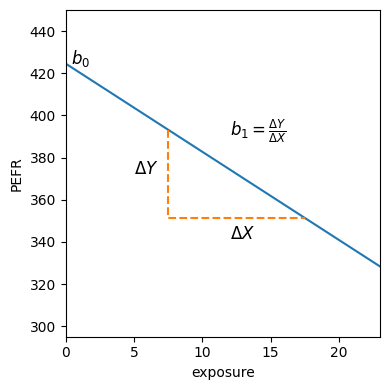

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel("exposure")
ax.set_ylabel("PEFR")
ax.plot((0, 23), model.predict(pl.DataFrame({"exposure": [0, 23]})))
ax.text(0.4, model.intercept_, r"$b_0$", size="larger")

x = pl.DataFrame({"exposure": [7.5, 17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), "--")
ax.text(5, np.mean(y), r"$\Delta Y$", size="larger")
ax.text(12, y[1] - 10, r"$\Delta X$", size="larger")
ax.text(12, 390, r"$b_1 = \frac{\Delta Y}{\Delta X}$", size="larger")

plt.tight_layout()
plt.show()

## Fitted Values and Residuals
The method `predict` of a fitted _scikit-learn_ model can be used to predict new data points.

In [12]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

In [13]:
ax = lung.plot.scatter(x="exposure", y="PEFR", figsize=(4, 4))
ax.plot(lung["exposure"], fitted)
for x, yactual, yfitted in zip(lung["exposure"], lung["PEFR"], fitted):
    ax.plot((x, x), (yactual, yfitted), "--", color="C1")

plt.tight_layout()
plt.show()

AttributeError: 'Scatter' object has no attribute 'plot'

# Multiple linear regression

In [72]:
subset = ["adjusted_sale_price", "sqft_total_living", "sqft_lot", "bathrooms",
          "bedrooms", "building_grade"]

house = (
    pl.read_parquet(HOUSE_PARQUET)
    .with_columns(
        pl.col("document_date").str.to_date(),
    )
)
print(house[subset].head())

shape: (5, 6)
┌─────────────────────┬───────────────────┬──────────┬───────────┬──────────┬────────────────┐
│ adjusted_sale_price ┆ sqft_total_living ┆ sqft_lot ┆ bathrooms ┆ bedrooms ┆ building_grade │
│ ---                 ┆ ---               ┆ ---      ┆ ---       ┆ ---      ┆ ---            │
│ f64                 ┆ i64               ┆ i64      ┆ f64       ┆ i64      ┆ i64            │
╞═════════════════════╪═══════════════════╪══════════╪═══════════╪══════════╪════════════════╡
│ 300805.0            ┆ 2400              ┆ 9373     ┆ 3.0       ┆ 6        ┆ 7              │
│ 1.076162e6          ┆ 3764              ┆ 20156    ┆ 3.75      ┆ 4        ┆ 10             │
│ 761805.0            ┆ 2060              ┆ 26036    ┆ 1.75      ┆ 4        ┆ 8              │
│ 442065.0            ┆ 3200              ┆ 8618     ┆ 3.75      ┆ 5        ┆ 7              │
│ 297065.0            ┆ 1720              ┆ 8620     ┆ 1.75      ┆ 4        ┆ 7              │
└─────────────────────┴─────────────

In [60]:
predictors = ["sqft_total_living", "sqft_lot", "bathrooms",
              "bedrooms", "building_grade"]
outcome = "adjusted_sale_price"

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f"Intercept: {house_lm.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(predictors, house_lm.coef_):
    print(f" {name}: {coef}")

Intercept: -521871.368
Coefficients:
 sqft_total_living: 228.83060360240793
 sqft_lot: -0.06046682065307607
 bathrooms: -19442.840398321066
 bedrooms: -47769.95518521438
 building_grade: 106106.96307898081


## Assessing the Model
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score`.

In [61]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f"RMSE: {RMSE:.0f}")
print(f"r2: {r2:.4f}")

RMSE: 261220
r2: 0.5406


While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn"t add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [62]:
model = sm.OLS(house[outcome], house[predictors].with_columns(const=1))
results = model.fit()
print(results.summary())

ValueError: unrecognized data structures: <class 'polars.series.series.Series'> / <class 'polars.dataframe.frame.DataFrame'>

## Model Selection and Stepwise Regression

In [63]:
print(house)

shape: (22_687, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ document_ ┆ sale_pric ┆ property_ ┆ property_ ┆ … ┆ land_valu ┆ imps_valu ┆ zip_code ┆ new_const │
│ date      ┆ e         ┆ id        ┆ type      ┆   ┆ e         ┆ e         ┆ ---      ┆ ruction   │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ i64      ┆ ---       │
│ str       ┆ i64       ┆ i64       ┆ str       ┆   ┆ i64       ┆ i64       ┆          ┆ bool      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 2014-09-1 ┆ 280000    ┆ 1000102   ┆ Multiplex ┆ … ┆ 70000     ┆ 229000    ┆ 98002    ┆ false     │
│ 6         ┆           ┆           ┆           ┆   ┆           ┆           ┆          ┆           │
│ 2006-06-1 ┆ 1000000   ┆ 1200013   ┆ Single    ┆ … ┆ 203000    ┆ 590000    ┆ 98166    ┆ true      │
│ 6         ┆           ┆           ┆ Family    ┆   ┆           ┆      

In [65]:
predictors = ["sqft_total_living", "sqft_lot", "bathrooms", "bedrooms",
              "building_grade", "property_type", "nbr_living_units",
              "sqft_fin_basement", "year_built", "year_renovated",
              "new_construction"]

X = house.to_dummies(predictors, drop_first=True)
X = X.with_columns(
    new_construction=[1 if nc else 0 for nc in predictors["new_construction"]]
)

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

TypeError: list indices must be integers or slices, not str

We can use the `stepwise_selection` method from the _dmba_ package.

In [97]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model,
                                                verbose=True)

print()
print(f"Intercept: {best_model.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(best_variables, best_model.coef_):
    print(f" {name}: {coef}")

Variables: document_date, sale_price, property_id, property_type_Single Family, property_type_Townhouse, ym, zhvi_px, zhvi_idx, adjusted_sale_price, nbr_living_units, sqft_lot_1000, sqft_lot_10000, sqft_lot_10001, sqft_lot_100029, sqft_lot_10004, sqft_lot_10005, sqft_lot_10009, sqft_lot_1001, sqft_lot_10010, sqft_lot_10011, sqft_lot_10012, sqft_lot_10015, sqft_lot_10016, sqft_lot_10017, sqft_lot_10018, sqft_lot_100188, sqft_lot_10019, sqft_lot_1002, sqft_lot_10020, sqft_lot_10023, sqft_lot_10025, sqft_lot_10026, sqft_lot_10027, sqft_lot_10028, sqft_lot_10030, sqft_lot_10031, sqft_lot_10032, sqft_lot_10033, sqft_lot_10035, sqft_lot_10038, sqft_lot_10040, sqft_lot_10043, sqft_lot_10044, sqft_lot_10046, sqft_lot_10047, sqft_lot_10048, sqft_lot_10050, sqft_lot_10051, sqft_lot_10052, sqft_lot_10053, sqft_lot_10056, sqft_lot_10058, sqft_lot_10060, sqft_lot_10062, sqft_lot_10063, sqft_lot_10064, sqft_lot_10065, sqft_lot_10066, sqft_lot_10067, sqft_lot_100681, sqft_lot_10069, sqft_lot_1007, sq

UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>) -> None

## Weighted regression

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [73]:
house = (
    house
    .with_columns(
        year=pl.col("document_date").dt.year(),
    )
    .with_columns(
        weight=pl.col("year") - 2005,
    )
)

In [75]:
predictors = ["sqft_total_living", "sqft_lot", "bathrooms",
              "bedrooms", "building_grade"]
outcome = "adjusted_sale_price"

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house["weight"])

df = pl.concat([
    pl.DataFrame({
        "predictor": predictors,
        "house_lm": house_lm.coef_,
        "house_wt": house_wt.coef_,
    }),
    pl.DataFrame({
        "predictor": ["intercept"],
        "house_lm": house_lm.intercept_,
        "house_wt": house_wt.intercept_,
    })
])
print(df)

shape: (6, 3)
┌───────────────────┬────────────────┬────────────────┐
│ predictor         ┆ house_lm       ┆ house_wt       │
│ ---               ┆ ---            ┆ ---            │
│ str               ┆ f64            ┆ f64            │
╞═══════════════════╪════════════════╪════════════════╡
│ sqft_total_living ┆ 228.830604     ┆ 245.024089     │
│ sqft_lot          ┆ -0.060467      ┆ -0.292415      │
│ bathrooms         ┆ -19442.840398  ┆ -26085.970109  │
│ bedrooms          ┆ -47769.955185  ┆ -53608.876436  │
│ building_grade    ┆ 106106.963079  ┆ 115242.434726  │
│ intercept         ┆ -521871.368188 ┆ -584189.329446 │
└───────────────────┴────────────────┴────────────────┘


In [85]:
residuals = pl.DataFrame({
    "abs_residual_lm": np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    "abs_residual_wt": np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    "year": house["year"],
})
print(residuals.head())
# axes = residuals.boxplot(["abs_residual_lm", "abs_residual_wt"], by="year", figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

df = (
    residuals
    .group_by("year")
    .agg(
        pl.mean("abs_residual_lm").alias("mean_abs_residual_lm"),
        pl.mean("abs_residual_wt").alias("mean_abs_residual_wt"),
    )
)
print(df)
# for year, group in residuals.group_by("Year"):
#     print(year, np.mean(group["abs_residual_lm"]), np.mean(group["abs_residual_wt"]))

shape: (5, 3)
┌─────────────────┬─────────────────┬──────┐
│ abs_residual_lm ┆ abs_residual_wt ┆ year │
│ ---             ┆ ---             ┆ ---  │
│ f64             ┆ f64             ┆ i32  │
╞═════════════════╪═════════════════╪══════╡
│ 123750.814194   ┆ 107108.553965   ┆ 2014 │
│ 59145.413089    ┆ 96191.882094    ┆ 2006 │
│ 190108.725716   ┆ 187004.49288    ┆ 2007 │
│ 198788.774412   ┆ 196132.996857   ┆ 2008 │
│ 91774.996129    ┆ 84277.577512    ┆ 2013 │
└─────────────────┴─────────────────┴──────┘
shape: (10, 3)
┌──────┬──────────────────────┬──────────────────────┐
│ year ┆ mean_abs_residual_lm ┆ mean_abs_residual_wt │
│ ---  ┆ ---                  ┆ ---                  │
│ i32  ┆ f64                  ┆ f64                  │
╞══════╪══════════════════════╪══════════════════════╡
│ 2012 ┆ 169506.670053        ┆ 171874.424266        │
│ 2007 ┆ 147747.577959        ┆ 152848.523235        │
│ 2011 ┆ 169937.385744        ┆ 172950.876028        │
│ 2008 ┆ 142086.905943        ┆ 1463

# Factor variables in regression
## Dummy Variables Representation

In [86]:
print(house["property_type"].head())

shape: (10,)
Series: 'property_type' [str]
[
	"Multiplex"
	"Single Family"
	"Single Family"
	"Single Family"
	"Single Family"
	"Townhouse"
	"Single Family"
	"Single Family"
	"Single Family"
	"Multiplex"
]


In [87]:
print(house.to_dummies("property_type").head(6))

shape: (6, 26)
┌─────────────┬────────────┬─────────────┬─────────────┬───┬──────────┬────────────┬──────┬────────┐
│ document_da ┆ sale_price ┆ property_id ┆ property_ty ┆ … ┆ zip_code ┆ new_constr ┆ year ┆ weight │
│ te          ┆ ---        ┆ ---         ┆ pe_Multiple ┆   ┆ ---      ┆ uction     ┆ ---  ┆ ---    │
│ ---         ┆ i64        ┆ i64         ┆ x           ┆   ┆ i64      ┆ ---        ┆ i32  ┆ i32    │
│ date        ┆            ┆             ┆ ---         ┆   ┆          ┆ bool       ┆      ┆        │
│             ┆            ┆             ┆ u8          ┆   ┆          ┆            ┆      ┆        │
╞═════════════╪════════════╪═════════════╪═════════════╪═══╪══════════╪════════════╪══════╪════════╡
│ 2014-09-16  ┆ 280000     ┆ 1000102     ┆ 1           ┆ … ┆ 98002    ┆ false      ┆ 2014 ┆ 9      │
│ 2006-06-16  ┆ 1000000    ┆ 1200013     ┆ 0           ┆ … ┆ 98166    ┆ true       ┆ 2006 ┆ 1      │
│ 2007-01-29  ┆ 745000     ┆ 1200019     ┆ 0           ┆ … ┆ 98166    ┆ fals

In [89]:
print(house.to_dummies("property_type", drop_first=True).head(6))

shape: (6, 25)
┌─────────────┬────────────┬─────────────┬─────────────┬───┬──────────┬────────────┬──────┬────────┐
│ document_da ┆ sale_price ┆ property_id ┆ property_ty ┆ … ┆ zip_code ┆ new_constr ┆ year ┆ weight │
│ te          ┆ ---        ┆ ---         ┆ pe_Single   ┆   ┆ ---      ┆ uction     ┆ ---  ┆ ---    │
│ ---         ┆ i64        ┆ i64         ┆ Family      ┆   ┆ i64      ┆ ---        ┆ i32  ┆ i32    │
│ date        ┆            ┆             ┆ ---         ┆   ┆          ┆ bool       ┆      ┆        │
│             ┆            ┆             ┆ u8          ┆   ┆          ┆            ┆      ┆        │
╞═════════════╪════════════╪═════════════╪═════════════╪═══╪══════════╪════════════╪══════╪════════╡
│ 2014-09-16  ┆ 280000     ┆ 1000102     ┆ 0           ┆ … ┆ 98002    ┆ false      ┆ 2014 ┆ 9      │
│ 2006-06-16  ┆ 1000000    ┆ 1200013     ┆ 1           ┆ … ┆ 98166    ┆ true       ┆ 2006 ┆ 1      │
│ 2007-01-29  ┆ 745000     ┆ 1200019     ┆ 1           ┆ … ┆ 98166    ┆ fals

In [91]:
predictors = ["sqft_total_living", "sqft_lot", "bathrooms", "bedrooms",
              "building_grade", "property_type"]

X = house.to_dummies(predictors, drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f"Intercept: {house_lm_factor.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f" {name}: {coef}")

TypeError: float() argument must be a string or a real number, not 'datetime.date'

## Factor Variables with many levels

In [92]:
print(pl.DataFrame(house["zip_code"].value_counts()).transpose())

shape: (2, 80)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_0 ┆ column_1 ┆ column_2 ┆ column_3 ┆ … ┆ column_76 ┆ column_77 ┆ column_78 ┆ column_79 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 98042    ┆ 98105    ┆ 98115    ┆ 98075    ┆ … ┆ 98023     ┆ 98027     ┆ 98043     ┆ 98003     │
│ 641      ┆ 313      ┆ 620      ┆ 388      ┆ … ┆ 455       ┆ 366       ┆ 1         ┆ 241       │
└──────────┴──────────┴──────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘


In [95]:
house = pl.read_parquet(HOUSE_PARQUET)

predictors = ["sqft_total_living", "sqft_lot", "bathrooms",
              "bedrooms", "building_grade"]
outcome = "adjusted_sale_price"

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pl.DataFrame([
    *pl.DataFrame({
        "zip_code": house["zip_code"],
        "residual" : house[outcome] - house_lm.predict(house[predictors]),
    })
    .group_by(["zip_code"])
    .apply(lambda x: {
        "zip_code": x.iloc[0, 0],
        "count": len(x),
        "median_residual": x.residual.median()
    })
]).sort_values("median_residual")
zip_groups["cum_count"] = np.cumsum(zip_groups["count"])
zip_groups["zip_group"] = pd.qcut(zip_groups["cum_count"], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups["zip_group"].value_counts().sort_index())

/tmp/ipykernel_86672/3872846638.py:17: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_groups`.
  .apply(lambda x: {


TypeError: cannot call `map_groups` when grouping by an expression

In [ ]:
to_join = zip_groups[["zip_code", "zip_group"]].set_index("zip_group")
house = house.join(to_join, on="zip_group")
house["zip_group"] = house["zip_group"].astype("category")

# Interpreting the Regression Equation
## Correlated predictors

The results from the stepwise regression are.

In [96]:
print(f"Intercept: {best_model.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(best_variables, best_model.coef_):
    print(f" {name}: {coef}")

NameError: name 'best_model' is not defined

In [98]:
predictors = ["bedrooms", "building_grade", "property_type", "year_built"]
outcome = "adjusted_sale_price"

X = house.to_dummies(predictors, drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f"Intercept: {reduced_lm.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f" {name}: {coef}")

ValueError: could not convert string to float: '2014-09-16'

## Confounding variables

In [ ]:
predictors = ["sqft_total_living", "sqft_lot", "bathrooms", "bedrooms",
              "building_grade", "property_type", "zip_group"]
outcome = "adjusted_sale_price"

X = house.to_dummies(predictors, drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f"Intercept: {confounding_lm.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f" {name}: {coef}")

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580154
 SqFtLot: 0.45498713854658845
 Bathrooms: 5928.42564000163
 Bedrooms: -41682.87184074476
 BldgGrade: 98541.18352725972
 PropertyType_Single Family: 19323.6252879192
 PropertyType_Townhouse: -78198.720927624
 ZipGroup_1: 53317.17330659817
 ZipGroup_2: 116251.58883563551
 ZipGroup_3: 178360.53178793378
 ZipGroup_4: 338408.60185652034


## Interactions and Main Effects

In [99]:
model = smf.ols(
    formula="adjusted_sale_price ~ sqft_total_living * zip_group + sqft_lot + " +
     "bathrooms + bedrooms + building_grade + property_type",
     data=house
)
results = model.fit()
print(results.summary())

TypeError: Cannot interpret 'String' as a data type

> Results differ from R due to different binning. Enforcing the same binning gives identical results

# Testing the Assumptions: Regression Diagnostics
## Outliers

The _statsmodels_ package has the most developed support for outlier analysis. 

In [101]:
house_98105 = house.filter(pl.col("zip_code") == 98105)

predictors = ["sqft_total_living", "sqft_lot", "bathrooms", "bedrooms",
              "building_grade"]
outcome = "adjusted_sale_price"

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].with_columns(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

ValueError: unrecognized data structures: <class 'polars.series.series.Series'> / <class 'polars.dataframe.frame.DataFrame'>

The `OLSInfluence` class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals. 

In [ ]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.326731804078564


In [ ]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115829


In [ ]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print("AdjSalePrice", outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


## Influential values

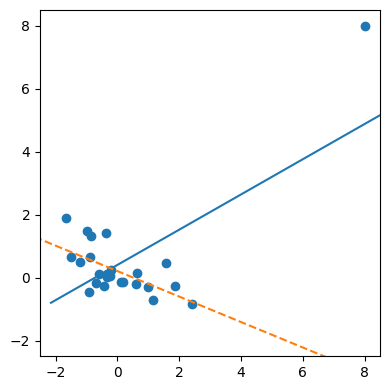

In [ ]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), "--")
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

The package _statsmodel_ provides a number of plots to analyze the data point influence

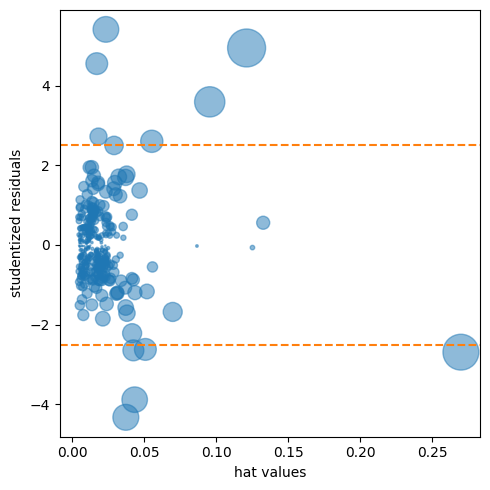

In [ ]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle="--", color="C1")
ax.axhline(2.5, linestyle="--", color="C1")
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel("hat values")
ax.set_ylabel("studentized residuals")

plt.tight_layout()
plt.show()

In [ ]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    "Original": result_98105.params,
    "Influential removed": result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Heteroskedasticity, Non-Normality and Correlated Errors

The `regplot` in _seaborn_ allows adding a lowess smoothing line to the scatterplot.

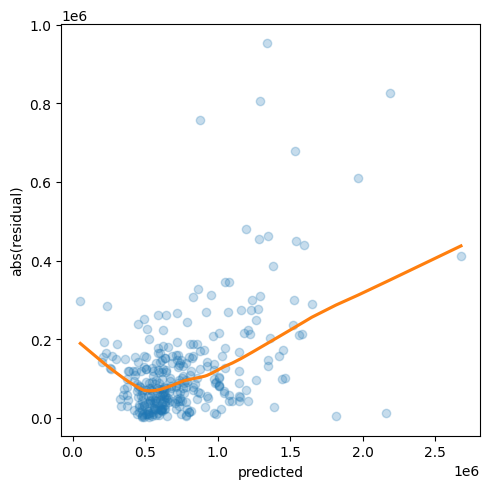

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid),
            scatter_kws={"alpha": 0.25},
            line_kws={"color": "C1"},
            lowess=True, ax=ax)
ax.set_xlabel("predicted")
ax.set_ylabel("abs(residual)")

plt.tight_layout()
plt.show()

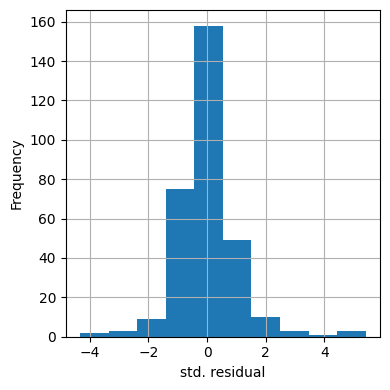

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel("std. residual")
ax.set_ylabel("Frequency")


plt.tight_layout()
plt.show()

## Partial Residual Plots and Nonlinearity

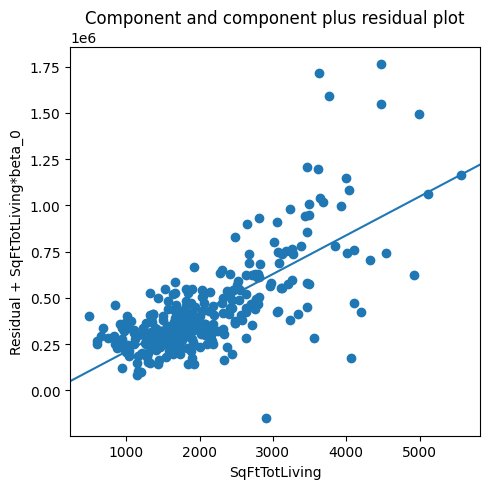

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, "SqFtTotLiving", ax=ax)

plt.tight_layout()
plt.show()

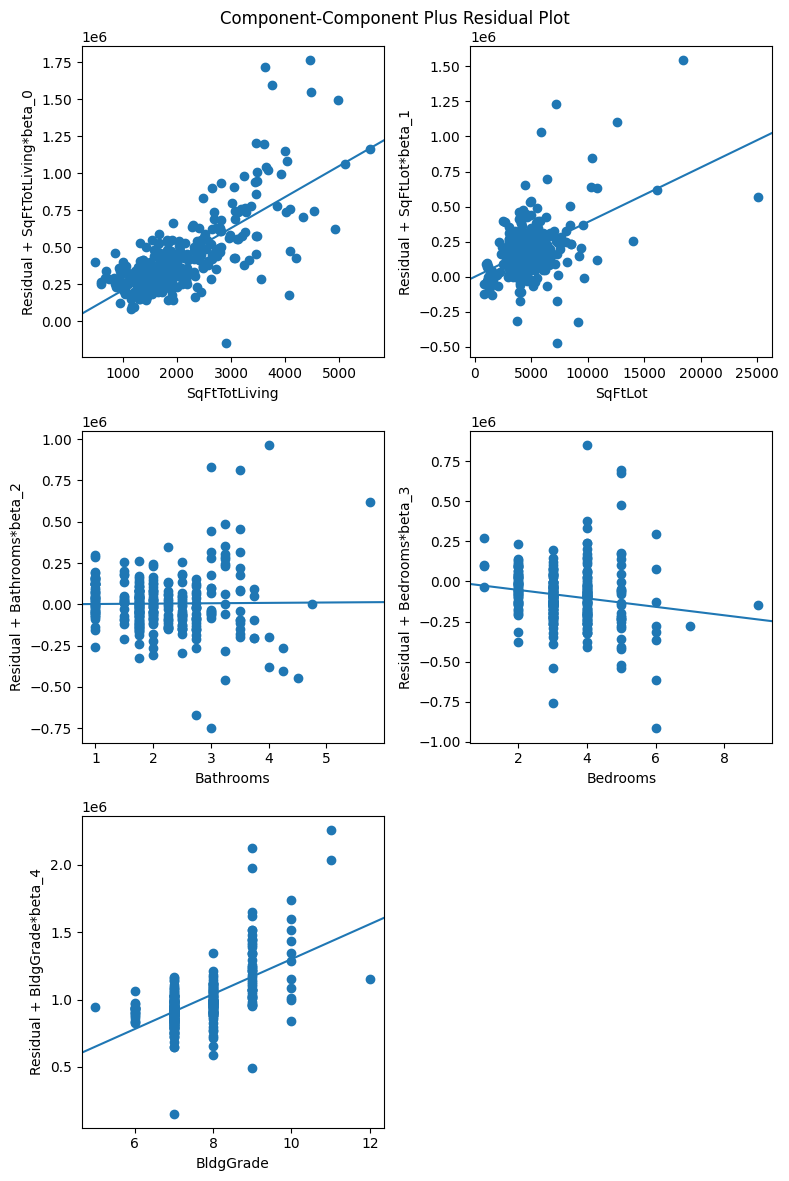

In [ ]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## Polynomial and Spline Regression

In [ ]:
model_poly = smf.ols(formula="AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + " +
                "SqFtLot + Bathrooms + Bedrooms + BldgGrade", data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 23 May 2023   Prob (F-statistic):          9.95e-106
Time:                        22:26:12   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

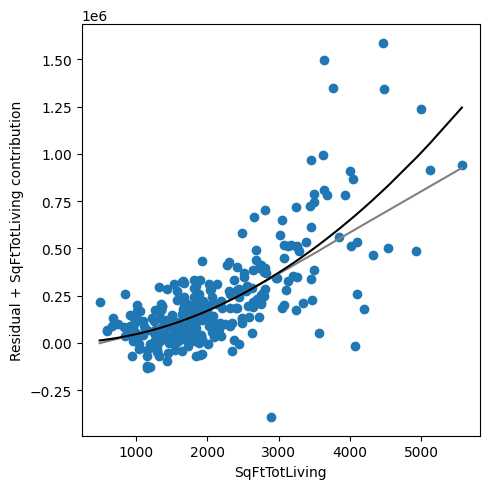

0.0387912816823115


In [ ]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        "feature": df[feature],
        "residual": df[outcome] - y_pred,
        "ypartial": feature_prediction - model.params[0],
    })
    results = results.sort_values(by=["feature"])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)

    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color="gray")
    ax.plot(results.feature, results.ypartial, color="black")
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Residual + {feature} contribution")
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, "AdjSalePrice", "SqFtTotLiving", ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Splines

In [ ]:
formula = ("AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + " +
           "SqFtLot + Bathrooms + Bedrooms + BldgGrade")
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 23 May 2023   Prob (F-statistic):          7.10e-104
Time:                        22:26:13   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


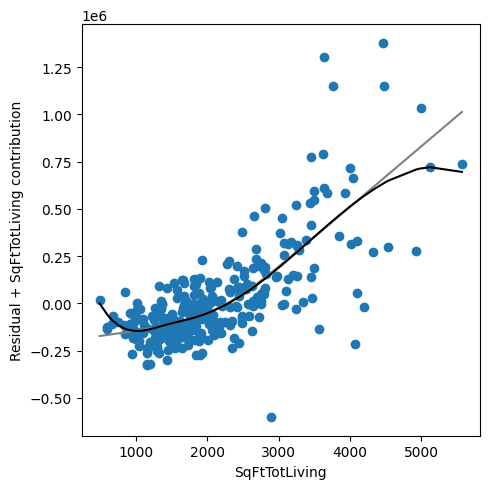

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, "AdjSalePrice", "SqFtTotLiving", ax)

plt.tight_layout()
plt.show()

## Generalized Additive Models

### Using statsmodels

In [ ]:
from statsmodels.gam.api import GLMGam, BSplines

predictors = ["SqFtTotLiving", "SqFtLot", "Bathrooms", "Bedrooms", "BldgGrade"]
outcome = "AdjSalePrice"

x_spline = house_98105[predictors]
bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)
# penalization weight
alpha = np.array([0] * 5)

formula = ("AdjSalePrice ~ SqFtTotLiving + " +
           "SqFtLot + Bathrooms + Bedrooms + BldgGrade")

gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                      295
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               Identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Tue, 23 May 2023   Deviance:                   8.1039e+12
Time:                        22:26:13   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

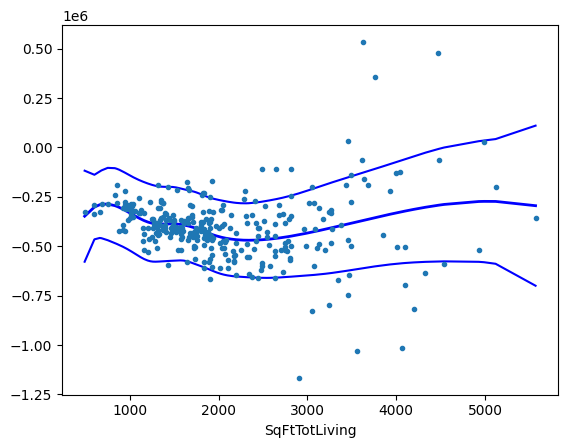

In [ ]:
res_sm.plot_partial(0, cpr=True);

### Using pyGAM

In [ ]:
predictors = ["SqFtTotLiving", "SqFtLot", "Bathrooms",
              "Bedrooms", "BldgGrade"]
outcome = "AdjSalePrice"
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1676
                                                Scale:                                    29480381715.8292
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

/tmp/ipykernel_63/661170992.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


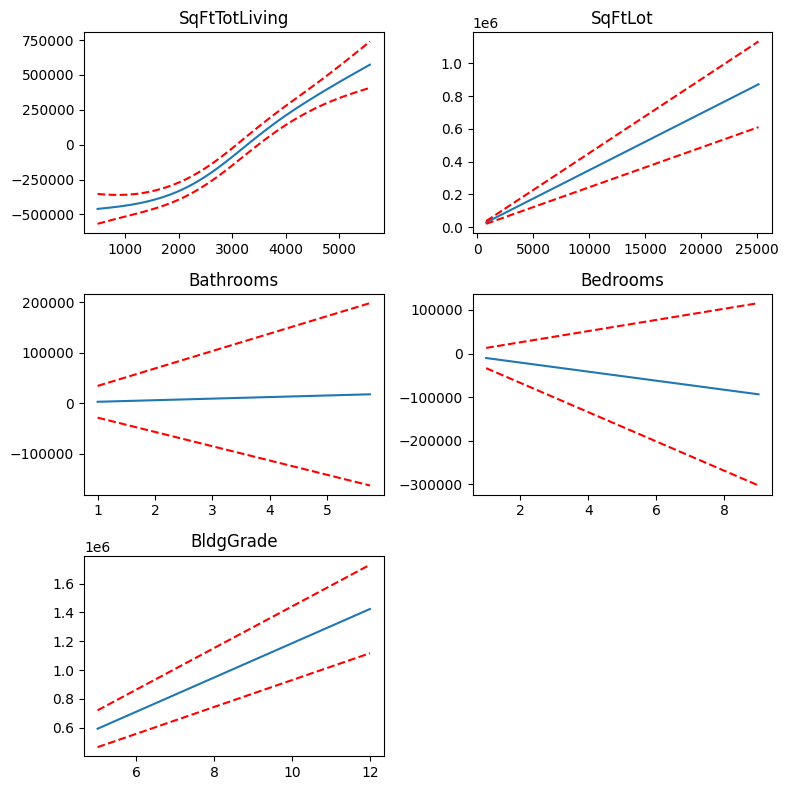

In [ ]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ["SqFtTotLiving", "SqFtLot", "Bathrooms", "Bedrooms", "BldgGrade"]
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);

axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# Additional material - not in book
# Regularization
## Lasso

In [ ]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [ ]:
subset = ["AdjSalePrice", "SqFtTotLiving", "SqFtLot", "Bathrooms",
          "Bedrooms", "BldgGrade"]

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [ ]:
predictors = ["SqFtTotLiving", "SqFtLot", "Bathrooms", "Bedrooms",
              "BldgGrade", "PropertyType", "NbrLivingUnits",
              "SqFtFinBasement", "YrBuilt", "YrRenovated",
              "NewConstruction"]
outcome = "AdjSalePrice"

X = pd.get_dummies(house[predictors], drop_first=True)
X["NewConstruction"] = [1 if nc else 0 for nc in X["NewConstruction"]]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression()


In [ ]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10)


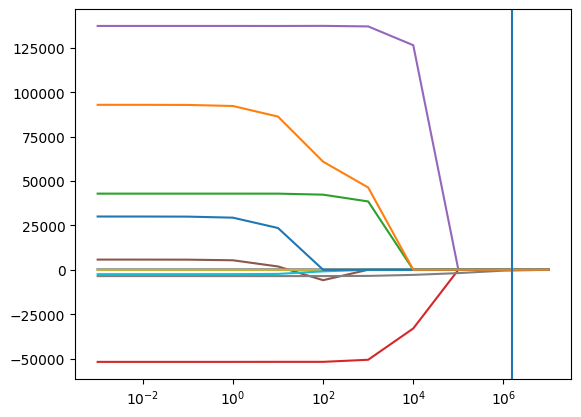

In [ ]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [ ]:
pl.DataFrame({
    "name": columns,
    "coef": modelCV.coef_,
})

,name,coef
0,SqFtTotLiving,289.048846
1,SqFtLot,0.029471
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.316479
7,YrBuilt,-0.000000
8,YrRenovated,45.727472
9,NewConstruction,-0.000000


In [ ]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308